In [1]:
import pandas as pd
import numpy as np
import copy
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, LeaveOneOut, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
filename = './머신러닝데이터.xlsx'

In [4]:
# Imputation한 데이터를 불러온다
scoring_transition_1 = pd.read_excel(filename, sheet_name='scoring_result_merged', engine='openpyxl')
scoring_transition_0 = pd.read_excel(filename, sheet_name='scoring_origin', engine='openpyxl')
task_completion_time = pd.read_excel(filename, sheet_name='task_completion_time_mean_imput', engine='openpyxl')
sms_reply = pd.read_excel(filename, sheet_name='SMS_reply', engine='openpyxl')
weather_searching_site_region = pd.read_excel(filename, sheet_name='weather_searching_사이트주소', engine='openpyxl')

In [5]:
# BAC column만 가져온다(Label)
y = scoring_transition_1['BAC']

# Participant, BAC column을 제거한다
scoring_transition_1 = scoring_transition_1.drop(['Participant', 'BAC'], axis=1)
scoring_transition_0 = scoring_transition_0.drop(['Participant', 'BAC'], axis=1)
task_completion_time = task_completion_time.drop(['Participant', 'BAC'], axis=1)
sms_reply = sms_reply.drop(['Participant', 'BAC'], axis=1)
weather_searching_site_region = weather_searching_site_region.drop(['Participant', 'BAC'], axis=1)

# 모든 Feature List
sms_reply, weather_searching_사이트주소는 feature 리스트가 같습니다

In [6]:
# scoring = ['Routine_Screen_Unlock_Pattern', 'Routine_Phone_Register', 'Routine_Phone_Receive', 'Routine_SMS_Reply', 'Routine_Camera', 
# 'Routine_Location_Searching', 'Routine_Weather_Searching', 'Routine_Transfer', 'Routine_Location_Switching', 'Routine_Weather_Switching', 
# 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 'Transition_Camera', 'Transition_Location_Searching', 
# 'Transition_Weather_Searching', 'Transition_Transfer', 'Transition_Location_Switching', 'Transition_Weather_Switching', 'Result_Phone_Register', 
# 'Result_Phone_Receive', 'Result_SMS_Reply', 'Result_Camera', 'Result_Location_Searching', 'Result_Weather_Searching', 'Result_Transfer', 
# 'Result_Location_Switching', 'Result_Weather_Switching', 'routine_sum_trial', 'transition_sum_trial', 'result_sum_trial', 'all_sum_trial']

# task = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_total_time_nt', 
# 'phone_register_screen_unlocking_time', 'phone_register_sms_start_time', 'phone_register_instruction_check_time', 'phone_register_total_time', 
# 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_noti response', 'phone_receive_total_time_nt', 'phone_receive_total_time', 
# 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_noti_response_time', 'sms_reply_total_time_nt', 'sms_reply_compeltion_time', 
# 'sms_reply_total_time', 'camera_noti_response', 'camera_total_time_nt', 'camera_instruction_check_time', 'camera_total_time', 'camera_taken_time', 
# 'camera_gallery_delete_time', 'transfer_noti_response_time', 'transfer_total_time_nt', 'transfer_instruction_check_time', 'transfer_total_time', 
# 'transfer_usage_time', 'transfer_share_time', 'weather_searching_noti_response', 'weather_searching_total_time_nt', 'weather_searching_instruction_check_time', 
# 'weather_searching_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_switching_notification_response_time', 
# 'weather_switching_total_time_nt', 'weather_switching_instruction_check_time', 'weather_switching_total_time', 
# 'weather_switching_first_searching_keyword_typing_time', 'weather_switching_second_searching_keyword_typing_time', 
# 'weather_switching_information_searching_time', 'weather_switching_information_sharing_texting_time', 'location_searching_noti_response_time', 
# 'location_searching_total_time_nt', 'location_searching_instruction_check_time', 'location_searching_total_time', 'location_searching_food_typing_time', 
# 'location_searching_foodtyping_mapfinding_time', 'location_searching_mapfinding_time', 'location_searching_route_sharing_texting_time', 
# 'location_switching_notification_response', 'location_switching_total_time_nt', 'location_switching_instruction_check', 'location_switching_total_time', 
# 'location_switching_first_map_typing_time', 'location_switching_second_map_typing_time', 'location_switching_map_finding_time', 
# 'location_switching_map_route_sharing_time']

# sms_and_ws = ['average intercharacter time', 'std intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
# 'total_time (S)', 'total_count', 'IS (C+IF+INF+F)', 'backspace (F)', 'C', 'IF', 'INF', 'Shift', 'ISø (IS+S)', 'T (total_count-F)', 'WPS', 'WPM', 'AdjWPS', 
# 'AdjWPM', 'CPS', 'KSPS', 'GPS', 'KSPC', 'GPC', 'MSD', 'COER', 'UER', 'TER', 'CE', 'PC', 'UB', 'WB', 'CPC']

# 가져오려는 feature명 적기

In [7]:
# 라벨 3개용 features
# 각 데이터별로 필요한 column들만 뽑는다
scoring_transition_1_columns = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns = []

task_completion_time_columns = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

In [8]:
# 라벨을 2개용 features
scoring_transition_1_columns_two_label = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns_two_label = []

task_completion_time_columns_two_label = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

In [9]:
# 위에서 정한 feature들로 각각의 데이터 프레임을 생성한다
scoring_transition_1_df = scoring_transition_1[scoring_transition_1_columns]
scoring_transition_0_df = scoring_transition_0[scoring_transition_0_columns]
task_completion_time_df = task_completion_time[task_completion_time_columns]
sms_reply_df = sms_reply[sms_reply_columns]
weather_searching_site_region_df = weather_searching_site_region[weather_searching_site_region_columns]

scoring_transition_1_df_two_label = scoring_transition_1[scoring_transition_1_columns_two_label]
scoring_transition_0_df_two_label = scoring_transition_0[scoring_transition_0_columns_two_label]
task_completion_time_df_two_label = task_completion_time[task_completion_time_columns_two_label]
sms_reply_df_two_label = sms_reply[sms_reply_columns_two_label]
weather_searching_site_region_df_two_label = weather_searching_site_region[weather_searching_site_region_columns_two_label]

# feature명 수정하기
위에서 적은 feature명을 그대로 복사해서 가져온 다음 바꾸려는 feature만 수정하면 됩니다

In [10]:
# 라벨 3개용 features의 feature명을 수정한다!
scoring_transition_1_columns = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns = []

task_completion_time_columns = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

scoring_transition_1_df.columns = scoring_transition_1_columns
scoring_transition_0_df.columns = scoring_transition_0_columns
task_completion_time_df.columns = task_completion_time_columns
sms_reply_df.columns = sms_reply_columns
weather_searching_site_region_df.columns = weather_searching_site_region_columns

In [11]:
# 라벨을 2개용 features의 feature명을 수정한다!
scoring_transition_1_columns_two_label = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns_two_label = []

task_completion_time_columns_two_label = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

scoring_transition_1_df_two_label.columns = scoring_transition_1_columns_two_label
scoring_transition_0_df_two_label.columns = scoring_transition_0_columns_two_label
task_completion_time_df_two_label.columns = task_completion_time_columns_two_label
sms_reply_df_two_label.columns = sms_reply_columns_two_label
weather_searching_site_region_df_two_label.columns = weather_searching_site_region_columns_two_label

In [12]:
# sms reply와 weather searching 사이트 주소의 feature명이 똑같으므로 feature명을 수정한다
sms_reply_df_columns = ['sms_' + col_name for col_name in sms_reply_df.columns] # sms reply feature 이름 앞에 sms_를 붙인다
weather_searching_site_region_df_columns = ['ws_' + col_name for col_name in weather_searching_site_region_df.columns] # ws feature 이름 앞에 ws_를 붙인다

sms_reply_df.columns = sms_reply_df_columns # 수정된 sms reply feature명을 적용한다
weather_searching_site_region_df.columns = weather_searching_site_region_df_columns # 수정된 ws feature명을 적용한다

# 위와 동일하게 작동한다
sms_reply_df_two_label_columns = ['sms_' + col_name for col_name in sms_reply_df_two_label.columns]
weather_searching_site_region_df_two_label_columns = ['ws_' + col_name for col_name in weather_searching_site_region_df_two_label.columns]

sms_reply_df_two_label.columns = sms_reply_df_two_label_columns
weather_searching_site_region_df_two_label.columns = weather_searching_site_region_df_two_label_columns

### merged_df : Label 3개인 데이터 집합
### merged_df_two_label : Label 2개인 데이터 집합

In [13]:
# 필요한 데이터 프레임들을 합친다
merged_df_list = [scoring_transition_1_df, scoring_transition_0_df, task_completion_time_df, sms_reply_df, weather_searching_site_region_df]
merged_df_list_two_label = [scoring_transition_1_df_two_label, scoring_transition_0_df_two_label, task_completion_time_df_two_label, 
sms_reply_df_two_label, weather_searching_site_region_df_two_label]

merged_df = pd.concat(merged_df_list, axis=1)
merged_df_two_label = pd.concat(merged_df_list_two_label, axis=1)

In [14]:
# Categorical 데이터에 대해서 인코딩한다
# 어떤 데이터가 Categorical 데이터인가?

# 라벨에 대해서 인코딩한다
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

### N : 3개 라벨에 대한 feature 개수 / M : 2개 라벨에 대한 feature 개수
merged_df.shape = (360, N), y.shape = (360, 1), 라벨 수: 3 </br>
merged_df_two_label.shape = (360, M), changed_label.shape = (360, 1), 라벨 수: 2 </br>
changed_df.shape = (240, M), changed_y.shape = (240, 1), 라벨 수: 2 </br>

In [15]:
# 라벨에 대해서 인코딩한다(0 -> 0, 0.06 -> 1, 0.09 -> 2)
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

# 3개의 라벨을 2개의 라벨로 바꾼다
changed_label = copy.deepcopy(y)

for i in range(len(changed_label)):
    if changed_label[i] == 1:
        changed_label[i] = 0

for i in range(len(changed_label)):
    if changed_label[i] == 2:
        changed_label[i] = 1

# 라벨 0과 라벨 0.06의 평균을 구해서 하나의 라벨로 만든다
temp_y = pd.Series(y, name='Label')
temp_df = pd.concat([temp_y, merged_df_two_label], axis=1)

changed_df = pd.DataFrame(columns=temp_df.columns)

num = 0
for row_idx in range(0, len(temp_df), 9):
    for i in range(3):
        changed_df.loc[num] = (temp_df.loc[row_idx + i] + temp_df.loc[row_idx + i + 3])/2
        num += 1
    for i in range(3):
        changed_df.loc[num] = temp_df.loc[row_idx + 6 + i]
        num += 1

changed_y = changed_df['Label']
changed_df = changed_df.drop(['Label'], axis=1)
changed_y = encoder.fit_transform(changed_y)

# 3 Labels, 2 Labels(just change), 2 Labels(average)에 대한 데이터
label_processing = ['3 Labels', '2 Labels(just change)', '2 Labels(average)']
data_list = [(merged_df, y), (merged_df_two_label, changed_label), (changed_df, changed_y)]

In [16]:
# Cross Validation의 평균 accuracy를 반환하는 함수
def runCV(X, y, clf, cv='loso', clf_explain='Certain Model', scale_explain='Certain Scale', label_explain='Certain Label'):
    # 클래스가 몇 개인지 확인한다
    class_nums = len(set(y))

    # cv가 loso라면 LosoCV를 적용한다
    if cv == 'loso':
        n_splits = 40
        kfold = KFold(n_splits=n_splits)
        leave_method = kfold

    # cv가 loocv라면 LooCV를 적용한다
    elif cv == 'loocv':
        loocv = LeaveOneOut()
        leave_method = loocv
    
    # 둘다 아니라면 에러를 발생시킨다
    else:
        raise ValueError("parameter cv must be 'loso' or 'loocv'!")

    y_true_list, y_pred_list = [], []
    y_pred_prob_list = []

    for train_idx, val_idx in leave_method.split(X):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        
        classifier = clone(clf)

        # 모델을 학습한다
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_val)
        y_pred_prob = classifier.predict_proba(X_val)
        
        # 실제, 예측 라벨을 저장한다
        y_true_list.extend(y_val)
        y_pred_list.extend(y_pred)

        # roc-auc score 계산을 위해 각 클래스별 예측 확률을 저장한다
        y_pred_prob_list.extend(y_pred_prob)

    accuracy = accuracy_score(y_true_list, y_pred_list)
    precision = precision_score(y_true_list, y_pred_list, average='macro')
    recall = recall_score(y_true_list, y_pred_list, average='macro')
    f1 = f1_score(y_true_list, y_pred_list, average='macro')
    if class_nums > 2:
        roc_auc = roc_auc_score(y_true_list, y_pred_prob_list, average='macro', multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_true_list, y_pred_list)
    
    print(f'Used {clf_explain} And {cv.capitalize()} And {scale_explain} And {label_explain}')
    print(accuracy)

    score_result = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return score_result

In [17]:
result_df = pd.DataFrame(columns=['model', 'cross validation method', 'scaling_method', 'label', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])

for (X_raw, y), label_processing_name in zip(data_list, label_processing):
    # 합친 데이터 프레임에 대하여 MinMax Scaling, MaxAbs Scaling, Standard Scaling, Robust Scaling을 진행한다
    min_max_df = X_raw.copy()
    max_abs_df = X_raw.copy()
    standard_df = X_raw.copy()
    robust_df = X_raw.copy()
    normalize_df = X_raw.copy()

    # 각각의 스케일러를 생성한다
    min_max_scaler = MinMaxScaler()
    max_abs_scaler = MaxAbsScaler()
    standard_scaler = StandardScaler()
    robust_scaler = RobustScaler()

    # 컬럼별로 스케일링을 진행한다
    min_max_df[min_max_df.columns] = min_max_scaler.fit_transform(min_max_df[min_max_df.columns])
    max_abs_df[max_abs_df.columns] = max_abs_scaler.fit_transform(max_abs_df[max_abs_df.columns])
    standard_df[standard_df.columns] = standard_scaler.fit_transform(standard_df[standard_df.columns])
    robust_df[robust_df.columns] = robust_scaler.fit_transform(robust_df[robust_df.columns])

    merged_scaled_df_list = [min_max_df, max_abs_df, standard_df, robust_df, X_raw]
    scaler_list = ['MinMaxScaler', 'MaxAbsScaler', 'StandardScaler', 'RobustScaler', 'NoScaler']

    for X, scaler_name in zip(merged_scaled_df_list, scaler_list):
        clf_list = [RandomForestClassifier(random_state=42), XGBClassifier(random_state=42), GradientBoostingClassifier(random_state=42), LGBMClassifier(random_state=42)]
        clf_name_list = ['RandomForestClassifier', 'XGBClassifier', 'GradientBoostingClassifier', 'LGBMClassifier']
        for clf, clf_name in zip(clf_list, clf_name_list):
            score_result = runCV(X, y, clf, 'loso', clf_explain=clf_name, scale_explain=scaler_name, label_explain=label_processing_name)
            result_row = [clf_name, 'Loso', scaler_name, label_processing_name] 
            result_row.extend([score_result['accuracy'], score_result['precision'], score_result['recall'], score_result['f1'], score_result['roc_auc']])
            result_df.loc[len(result_df)] = result_row

Used RandomForestClassifier And Loso And MinMaxScaler And 3 Labels
0.575


KeyboardInterrupt: 

In [ ]:
result_df

,model,cross validation method,scaling_method,label,accuracy,precision,recall,f1_score,roc_auc_score
0,RandomForestClassifier,Loso,MinMaxScaler,3 Labels,0.575000,0.569696,0.575000,0.571126,0.778322
1,XGBClassifier,Loso,MinMaxScaler,3 Labels,0.586111,0.582503,0.586111,0.583721,0.780127
2,GradientBoostingClassifier,Loso,MinMaxScaler,3 Labels,0.577778,0.573632,0.577778,0.574068,0.774074
3,LGBMClassifier,Loso,MinMaxScaler,3 Labels,0.580556,0.579261,0.580556,0.579628,0.780810
4,RandomForestClassifier,Loso,MaxAbsScaler,3 Labels,0.575000,0.569696,0.575000,0.571126,0.778270
5,XGBClassifier,Loso,MaxAbsScaler,3 Labels,0.586111,0.582503,0.586111,0.583721,0.780023
6,GradientBoostingClassifier,Loso,MaxAbsScaler,3 Labels,0.572222,0.568266,0.572222,0.568812,0.773310
7,LGBMClassifier,Loso,MaxAbsScaler,3 Labels,0.588889,0.586016,0.588889,0.586856,0.783333
8,RandomForestClassifier,Loso,StandardScaler,3 Labels,0.572222,0.567107,0.572222,0.568452,0.778362
9,XGBClassifier,Loso,StandardScaler,3 Labels,0.586111,0.582503,0.586111,0.583721,0.779873


In [ ]:
with pd.ExcelWriter(f"./run_result.xlsx") as writer:
    result_df.to_excel(writer, sheet_name="result", index=False)

# SHAP value를 시각화하기 위한 함수

In [ ]:
clf_list = {
    'rf': RandomForestClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42),
    'gbm': GradientBoostingClassifier(random_state=42),
    'lightgbm': LGBMClassifier(random_state=42)
}

scaler_list = {
    'minmax': MinMaxScaler(),
    'maxabs': MaxAbsScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

label_list = {
    'three_label': data_list[0],
    'two_label_changed': data_list[1],
    'two_label_average': data_list[2]
}

def showShap(clf_name, scaler_name, label_name):
    metric_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])

    if clf_name not in clf_list.keys():
        raise ValueError("clf_name must be 'rf' or 'xgb' or 'gbm' or 'lightgbm'!")

    if scaler_name not in scaler_list.keys() and scaler_name != 'no_scale':
        raise ValueError("scaler_name must be 'minmax' or 'maxabs' or 'standard' or 'robust' or 'no_scale!")

    if label_name not in label_list.keys():
        raise ValueError("label_name must be 'three_label' or 'two_label_changed' or 'two_label_average'!")

    clf = clf_list[clf_name]
    X, y = label_list[label_name]

    if scaler_name != 'no_scale':
        scaler = scaler_list[scaler_name]
        df = X.copy()

        df[df.columns] = scaler.fit_transform(df[df.columns])

        X = df
        X[X.columns] = scaler.fit_transform(X[X.columns])

    # 클래스가 몇 개인지 확인한다
    class_nums = len(set(y))

    n_splits = 40
    kfold = KFold(n_splits=n_splits)

    mean_accuracy = 0
    mean_precision = 0
    mean_recall = 0
    mean_f1 = 0
    mean_roc_auc = 0
    
    list_shap_values = list()
    list_test_sets = list()

    for num, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        
        classifier = clone(clf)

        # 모델을 학습한다
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_val)
        y_pred_prob = classifier.predict_proba(X_val)

        # 개별 performance metric을 구한다
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='macro')
        recall = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')
        if class_nums > 2:
            roc_auc = roc_auc_score(y_val, y_pred_prob, average='macro', multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_val, y_pred)
        
        # 개별 performance metric을 데이터 프레임으로 저장한다
        metric_df.loc[len(metric_df)] = [f'model_{num+1}', accuracy, precision, recall, f1, roc_auc]

        # 평균 performance metric을 구한다
        mean_accuracy += accuracy / n_splits
        mean_precision += accuracy / n_splits
        mean_recall += recall / n_splits
        mean_f1 += f1 / n_splits
        mean_roc_auc += roc_auc / n_splits

        # explaining model
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_val)
        
        list_shap_values.append(shap_values)
        list_test_sets.append(val_idx)

    print('mean accuracy : ', mean_accuracy)
    print('mean precision : ', mean_precision)
    print('mean recall : ', mean_recall)
    print('mean f1 : ', mean_f1)
    print('mean roc_auc : ', mean_roc_auc)

    metric_df.loc[len(metric_df)] = ['mean', mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc]

    # combining results from all iterations
    if class_nums > 2 or clf_name == 'lightgbm' or clf_name == 'rf':
        test_set = list_test_sets[0]
        shap_values = np.array(list_shap_values[0])
        for i in range(1,len(list_test_sets)):
            test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
            shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
        #bringing back variable names    
        X_test = pd.DataFrame(X.loc[test_set], columns=X.columns)
    else:
        test_set = list_test_sets[0]
        shap_values = np.array(list_shap_values[0])
        for i in range(1,len(list_test_sets)):
            test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
            shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        #bringing back variable names    
        X_test = pd.DataFrame(X.loc[test_set], columns=X.columns)

    return (shap_values, X_test, metric_df)


### clf_name = 'rf' or 'xgb' or 'gbm' or 'lightgbm' 
### scaler_name = 'minmax' or 'maxabs' or 'standard' or 'robust' or 'no_scale'
### label_name = 'three_label' or 'two_label_changed' or 'two_label_average'

In [ ]:
clf_name = 'xgb'
scaler_name = 'no_scale'
label_name = 'two_label_changed'

shap_values, X_test, metric_df = showShap(clf_name=clf_name, scaler_name=scaler_name, label_name=label_name)

mean accuracy :  0.8083333333333337
mean precision :  0.8083333333333337
mean recall :  0.766666666666667
mean f1 :  0.7474059274059277
mean roc_auc :  0.766666666666667


# 40개의 모델의 개별 performance metric + 평균 performanace metric을 저장한다
# 각 모델별 test set의 feature에 따른 shap value를 저장한다

# feature별 랭킹을 [mean |shap value|]로 계산한 후 feature 랭킹순으로 shap value를 저장한다

In [ ]:
if label_name == 'three_label':
    shap_values_df_0 = pd.DataFrame(shap_values[0], columns=X_test.columns)
    shap_values_df_1 = pd.DataFrame(shap_values[1], columns=X_test.columns)
    shap_values_df_2 = pd.DataFrame(shap_values[2], columns=X_test.columns)

    with pd.ExcelWriter(f"./default_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label' and (clf_name == 'lightgbm' or clf_name == 'rf'):
    shap_values_df = pd.DataFrame(shap_values[0], columns=X_test.columns)

    with pd.ExcelWriter(f"./default_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

if label_name != 'three_label' and (clf_name == 'xgb' or clf_name == 'gbm'):
    shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)

    with pd.ExcelWriter(f"./default_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

# Summary Plot

## 3 Label

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[0], X_test)

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[1], X_test)

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[2], X_test)

In [ ]:
if label_name == 'three_label':
    shap_values = [shap_values[0], shap_values[1], shap_values[2]]
    shap.summary_plot(shap_values, X_test, class_names=['BAC 0', 'BAC 0.06', 'BAC 0.09'], class_inds=[0, 1, 2])

# 2 Label (Lightgbm, Random Forest)

In [ ]:
if label_name != 'three_label' and (clf_name == 'lightgbm' or clf_name == 'rf'):
    shap.summary_plot(shap_values[0], X_test)

In [ ]:
if label_name != 'three_label' and (clf_name == 'lightgbm' or clf_name == 'rf'):
    shap.summary_plot(shap_values[1], X_test)

In [ ]:
if label_name != 'three_label' and (clf_name == 'lightgbm' or clf_name == 'rf'):
    shap_values = [shap_values[0], shap_values[1]]
    shap.summary_plot(shap_values, X_test, class_names=['BAC 0', 'BAC 0.09'], class_inds=[0, 1])

# 2 Labels (나머지 모델)

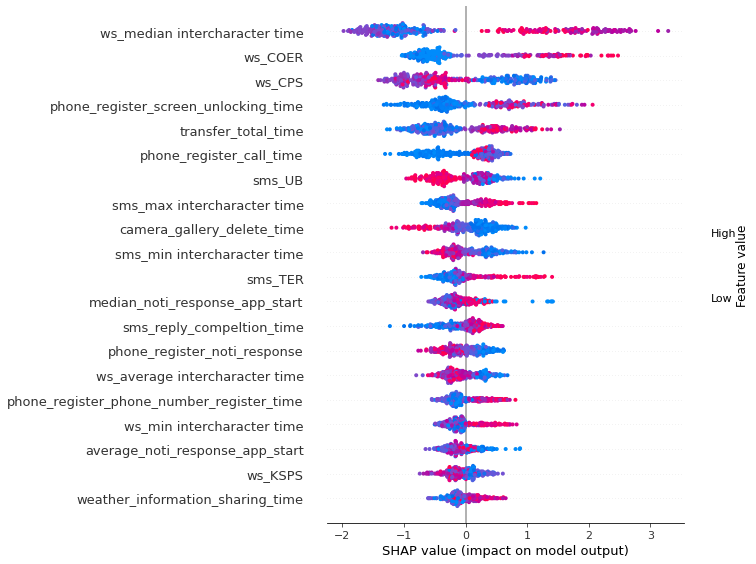

In [ ]:
if label_name != 'three_label' and (clf_name == 'xgb' or clf_name == 'gbm'):
    shap.summary_plot(shap_values, X_test)

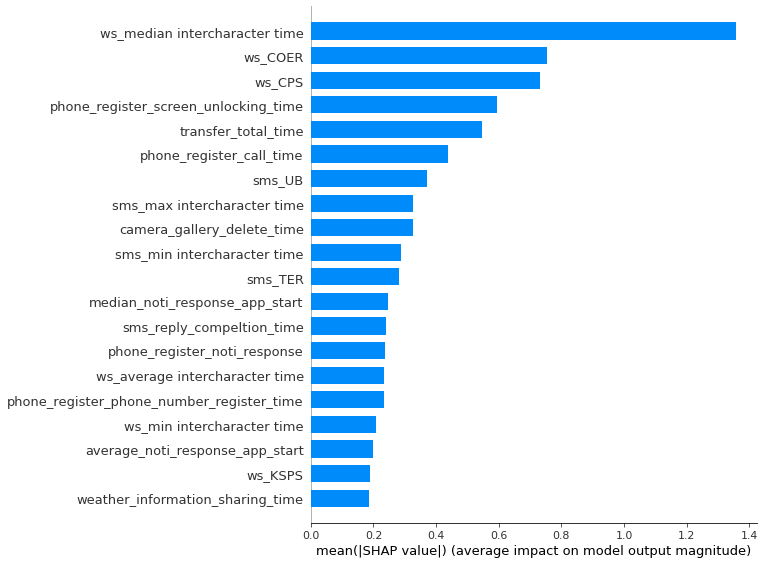

In [ ]:
if label_name != 'three_label' and (clf_name == 'xgb' or clf_name == 'gbm'):
    shap.summary_plot(shap_values, X_test, plot_type='bar')